# Multi-Element Airfoil

In [2]:
import numpy as np
import pandas as pd

import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp

import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import logging
logging.getLogger().setLevel(logging.INFO)

matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

In [6]:
# Read and panel airfoil data
MAIN = vft.read_selig("airfoils/main_element.dat")
MAIN = vft.repanel(MAIN, N = 200)[:,::-1] #180

# MAIN = vft.repanel(vft.read_selig("airfoils/NLR7301MainECARP.dat"), N = 200)[:,::-1] #180

FLAP0 = vft.read_selig("airfoils/flap.dat")[:,::-1]

FLAP0 = vft.repanel(vft.read_selig("airfoils/NLR7301FlapECARP.dat"), N = 220)[:,::-1] #150
_min = FLAP0[0].min()
FLAP0[0,:] += -_min

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

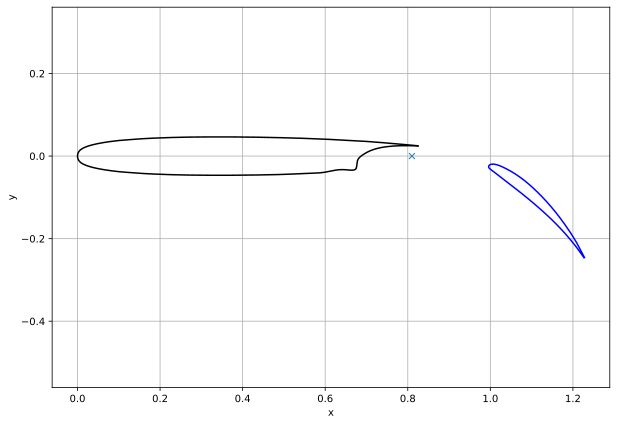

In [9]:
def rotate(deg, center, x):
    """Rotate airfoil.
    
    Parameters
    ----------
    deg : float
    center : numpy.array
    x : numpy.array
    
    Returns
    -------
    moved : numpy.array
    """

    # Create rotation matrix
    deg2rad = np.pi / 180
    c, s = np.cos(deg * deg2rad), np.sin(deg * deg2rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.
    moved = ((A @ ((x.T - center.T).T)).T + center.T).T
    # moved = ((A @ ((x.T).T)).T).T
    
    return moved


# Rotate flap
HINGE = 0.8 + 0.01
center = np.r_[HINGE, 0.0]

FLAP0[0, :] += HINGE
FLAP = rotate(30, center, FLAP0)
# FLAP = FLAP0
#FLAP[1, :] += 0.0025
FLAP[1, :] += -0.00
FLAP[0, :] += 0.2


# Plot geometry
fig, ax = plt.subplots(1, 1)
ax.plot(MAIN[0, :], MAIN[1, :], "-k")
ax.plot(FLAP[0, :], FLAP[1, :], "-b")
ax.plot(center[0], center[1], marker = "x")
ax.axis("equal")
ax.grid()
ax.set(xlabel = "x", ylabel="y")

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [ ]:
# Settings
RE = 2.83e6
ncrit = 12
MACH_0 = 0.185

# Angle of Attack
AOA_start = 0.1
AOA_stop = 5.0
N = 10
AOArange = np.linspace(start = AOA_start, stop = AOA_stop, num = N)

# Prepare problem
setup = vf.setup(Re=RE, Ncrit=ncrit, Ma=MACH_0, Alpha=AOArange[0], Itermax=1000)
setup.Silent = True  # Do not show information on convergence and iterations

# RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
setup.ShearLagType = 1

results = {}  # Dictionary of results

#  Set Mach number
setup.Ma = MACH_0

results = {}
results["AOA"] = []
results["CL"] = []
results["CLi"] = []
results["CD"] = []



for alpha in AOArange:

    setup.Alpha = alpha
    print(f"alpha: {alpha}")
    
    if Init:
        [p, bl, xn] = vf.init([MAIN, FLAP], setup)
        Init = False

    res = None
    grad = None
    [xn, flag, res, grad, _] = vf.iter(xn, bl, p, setup, res, grad)

    if bool(flag) == True:
        results["AOA"].append(alpha)
        results["CL"].append(p.CL)
        results["CLi"].append(p.CLi)
        results["CD"].append(bl[0].CD)
        print('AOA %2.2f CL %f'%(alpha,p.CL))

alpha: -5.0


AssertionError: Non real values occurred

Exception ignored in: 'ibl.ibl_classes.ibl_march_ue'
Traceback (most recent call last):
  File "ibl\ibl_solvers.pyx", line 1208, in ibl.ibl_classes.solve_ue_hk
AssertionError: Non real values occurred
 xi=0.847854,delta=0.000004,theta=0.000000,ue=2.795836,typ=laminar,
 res=[44.2986,-670.012,-523.597]
 dx=[7.81489e-07,-21.8027,-2004.07]
 x=[3.76609e-07,2.79584,-519.426] 
 lam=0.032058 H=10.353070 HS=1.574700 US=0.000000.

 xi=0.847854,delta=0.000002,theta=0.000001,ue=4.185949,typ=laminar,
 res=[-136.269,-59.9348,-2.86439e-16]
 dx=[-1.50751e-06,25.1284,2.86439e-16]
 x=[6.57778e-07,4.18595,4.17151] 
 lam=0.027764 H=3.232639 HS=1.569468 US=0.000000.

 xi=0.842164,delta=0.000006,theta=0.000002,ue=3.571648,typ=laminar,
 res=[-57.3959,-0.189365,-4.67582e-14]
 dx=[5.0099e-06,-21.1492,4.85345e-14]
 x=[1.72932e-06,3.57165,4.17146] 
 lam=0.042220 H=3.329582 HS=1.549269 US=0.000000.

 xi=0.847854,delta=0.000003,theta=0.000001,ue=3.015779,typ=turbulent,
 res=[-120.339,-48.6346,0.000686472]
 dx=[1.9

 xi=0.106717,delta=0.000013,theta=0.000004,ue=4.213482,typ=laminar,
 res=[-2.61522,0.187504,-3.89134e-16]
 dx=[1.0091e-06,-2.67378,3.89134e-16]
 x=[4.43434e-06,4.21348,2.27827] 
 lam=0.393963 H=2.862126 HS=1.608301 US=0.000000.

 xi=0.106717,delta=0.000013,theta=0.000004,ue=4.230640,typ=laminar,
 res=[-2.61072,0.174715,-3.89134e-16]
 dx=[9.65234e-07,-2.74917,3.89134e-16]
 x=[4.40051e-06,4.23064,2.28099] 
 lam=0.384720 H=2.883870 HS=1.606471 US=0.000000.

 xi=0.106717,delta=0.000013,theta=0.000004,ue=4.214459,typ=laminar,
 res=[-2.61264,0.187438,-3.89134e-16]
 dx=[1.00675e-06,-2.68059,3.89134e-16]
 x=[4.437e-06,4.21446,2.27862] 
 lam=0.393053 H=2.863842 HS=1.608134 US=0.000000.

 xi=0.106717,delta=0.000013,theta=0.000004,ue=4.204627,typ=laminar,
 res=[-2.61502,0.193796,-3.89134e-16]
 dx=[1.03614e-06,-2.65545,3.89134e-16]
 x=[4.45515e-06,4.20463,2.27711] 
 lam=0.395849 H=2.852652 HS=1.609039 US=0.000000.

 xi=0.106716,delta=0.000013,theta=0.000004,ue=4.224510,typ=laminar,
 res=[-2.7104,0

 xi=0.110914,delta=0.000008,theta=0.000003,ue=4.324460,typ=laminar,
 res=[-4.82808,0.905222,-4.40457e-20]
 dx=[-1.23245e-06,4.93437,4.40457e-20]
 x=[2.65552e-06,4.32446,0.00103776] 
 lam=0.146066 H=3.070329 HS=1.589971 US=0.000000.

 xi=0.806775,delta=0.000000,theta=0.000000,ue=3.367205,typ=turbulent,
 res=[-65608.7,-12408.5,0.01266]
 dx=[-1.06089e-07,8.84111,-0.00252282]
 x=[9.97875e-08,3.3672,1.71099] 
 lam=0.063476 H=1.302174 HS=1.946592 US=0.892473.

 xi=0.798839,delta=0.000010,theta=0.000004,ue=3.180379,typ=turbulent,
 res=[-14.5371,-30.6489,-0.000332072]
 dx=[5.20885e-08,-9.78811,0.0476406]
 x=[3.89822e-06,3.18038,0.0649683] 
 lam=0.081231 H=2.437987 HS=1.618387 US=0.329391.

 xi=0.782250,delta=0.000005,theta=0.000003,ue=3.002796,typ=laminar,
 res=[0.889693,-146.256,2.15011e-06]
 dx=[-9.44528e-06,-14.336,7.69829e-06]
 x=[2.50493e-06,3.0028,4.26681] 
 lam=0.052365 H=1.889522 HS=1.742738 US=0.000000.

 xi=0.798839,delta=0.000013,theta=0.000003,ue=5.126698,typ=turbulent,
 res=[-6.58

alpha: -3.888888888888889


AssertionError: Non real values occurred

Exception ignored in: 'ibl.ibl_classes.ibl_march_ue'
Traceback (most recent call last):
  File "ibl\ibl_solvers.pyx", line 1208, in ibl.ibl_classes.solve_ue_hk
AssertionError: Non real values occurred
 xi=0.847233,delta=0.000004,theta=0.000001,ue=3.004957,typ=turbulent,
 res=[-20.2498,-34.2816,-0.000185818]
 dx=[1.34645e-06,-18.7355,-0.07778]
 x=[1.20632e-06,3.00496,0.0375018] 
 lam=0.040097 H=3.355591 HS=1.540005 US=0.186584.

 xi=0.843819,delta=0.000006,theta=0.000002,ue=3.730042,typ=laminar,
 res=[-69.0291,21.0098,-5.6675e-11]
 dx=[1.17563e-06,-6.15275,6.67993e-11]
 x=[1.77763e-06,3.73004,4.03922] 
 lam=0.151560 H=3.114261 HS=1.565411 US=0.000000.

 xi=0.847233,delta=0.000010,theta=0.000002,ue=4.717629,typ=laminar,
 res=[-6.81241,-8.95331,68.7627]
 dx=[-5.74221e-07,7.07731,-100.603]
 x=[2.13243e-06,4.71763,75.2718] 
 lam=0.111098 H=4.490085 HS=1.532170 US=0.000000.

 xi=0.847233,delta=0.000010,theta=0.000002,ue=4.717629,typ=laminar,
 res=[-6.81241,-8.95331,68.7627]
 dx=[-5.74221e-07

In [ ]:
results_df = pd.DataFrame(results).set_index("AOA")

results_df.plot(subplots=True, grid=True)

---

In [ ]:
# Read experimental data
EXPRES=np.genfromtxt("NLRLIFTSLOPE.csv",delimiter=",",names=True)

fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['MEAS_X'],EXPRES['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Lift")
for val in Mach_vec:
    ax[0].plot(np.array(results[val]["AOA"]),np.asarray(results[val]["CL"]),marker=None,label="Calculation Mach %g"%val)
ax[0].plot(np.array(results[val]["AOA"]),results[val]["CLi"],marker=None,label="Inviscid Lift")

ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].legend()
ax[0].set_xlim([-2, 17])
ax[0].set_ylim([1.5, 3.5])

EXPRESD=np.genfromtxt("NLRDRAGSLOPE.csv",delimiter=",",names=True)
ax[1].plot(EXPRESD['MEAS_X'],EXPRESD['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Drag")
for val in Mach_vec:
    ax[1].plot(results[val]["AOA"],results[val]["CD"],marker=None,label="Calculation Mach %g"%val)

ax[1].set_ylim([0, 0.08]) 
ax[1].set_xlim([-2, 17])
ax[1].set_xlabel('AOA')
ax[1].set_ylabel('CD')
ax[1].legend();

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [ ]:
# Set-up and initialize based on inviscid panel solution
s.Ma = 0.0

# Experimental 6° has the same lift as numerical 5.5°
s.Alpha = 6
[p6,bl6,x] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl6,p6,s,None,None)

# Experimental 13.1° has the same lift as numerical 12.6°
s.Alpha = 13.1
[p13,bl13,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl13,p13,s,None,None)

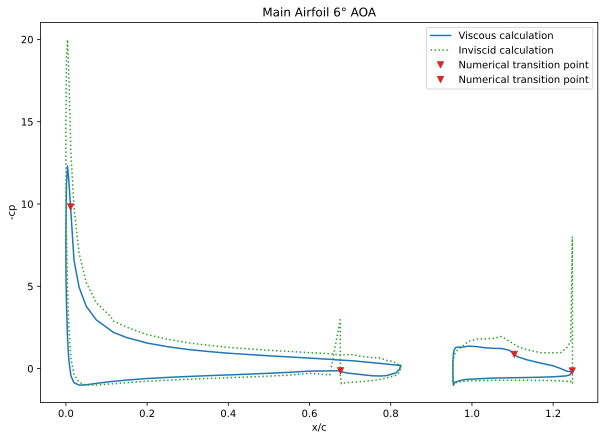

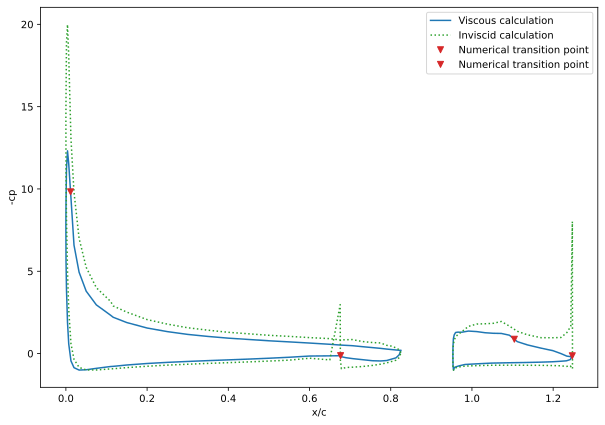

In [11]:

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax,EXPRES):
    ax.plot(EXPRES['EXPMAINCP_X'],EXPRES['EXPMAINCP_Y'],marker="o",linestyle = 'None', color="tab:blue",label="Experiment")
    ax.plot(EXPRES['EXPFLAPCP_X']+.1,EXPRES['EXPFLAPCP_Y'],marker="o",linestyle = 'None', color="tab:blue")
    ax.plot(EXPRES['EXPMAINTR_X'],EXPRES['EXPMAINTR_Y'],marker="D",linestyle = 'None', color="tab:orange",label="Experimental transition region")
    ax.plot(EXPRES['EXPFLAPTR_X']+.1,EXPRES['EXPFLAPTR_Y'],marker="D",linestyle = 'None', color="tab:orange")

# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax,p,bl):
    # A helper index, cp is a single array of pressures over all panel nodes
    IMF = [range(0,p.foils[0].N),range(p.foils[0].N,p.foils[0].N+p.foils[1].N)]
    
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp[IMF[0]],marker="None",color="tab:blue",label="Viscous calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp[IMF[1]],marker="None",color="tab:blue")
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp_inviscid[IMF[0]],':',marker="None",color="tab:green",label="Inviscid calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp_inviscid[IMF[1]],':',marker="None",color="tab:green")

    for k in range(2):
        tr_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        tr_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        cp_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        cp_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        ax.plot(tr_lo,-cp_lo,'v',color="tab:red",label="Numerical transition point")
        ax.plot(tr_up,-cp_up,'v',color="tab:red")

    ax.set_xlabel('x/c')
    ax.set_ylabel('-cp')

# Read and plot data for 6° AoA
#EXPRES=np.genfromtxt("NLRCP55.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
#plot_cp_exp(ax,EXPRES)
plot_cp(ax,p,bl)
ax.set_title('Main Airfoil 6° AOA')
ax.legend()

# Read and plot data for 13.1° AoA
#EXPRES=np.genfromtxt("NLRCP126.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
#plot_cp_exp(ax,EXPRES)
plot_cp(ax,p,bl)
ax.legend();



[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 